<a href="https://colab.research.google.com/github/hufsaim/T10306201/blob/master/notebook/Lab08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import pandas as pd
from PIL import Image
import requests
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!pip install pytorch-gradcam
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

     |████████████████████████████████| 6.0MB 5.2MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-cp36-none-any.whl size=5270 sha256=8b8e7ed55aa51ab60386b65126c4ead28f71a5ed0c30492f76cc7d51a1af3e53
  Stored in directory: /root/.cache/pip/wheels/e8/1e/35/d24150a078a90ce0ad093586814d4665e945466baa89907300
Successfully built pytorch-gradcam


In [3]:
idx2label = pd.read_csv('https://raw.githubusercontent.com/hufsbme/T10402101/master/ch7_modern_ConvNets/imagenet_class_index.csv')
idx2label = idx2label.to_numpy()
idx2label = idx2label[:,1]

## Download pre-trained model from torch hub
https://pytorch.org/hub/ 

In [4]:
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet101', pretrained=True)
net.eval()
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


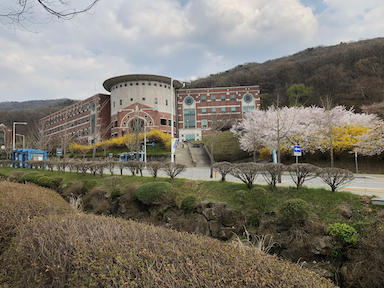

In [5]:
# sample execution (requires torchvision)

# web image
url  = 'https://raw.githubusercontent.com/hufsbme/T10402101/master/ch7_modern_ConvNets/hufs_campus.png'
input_image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

# google drive image
#url  = '/content/drive/My Drive/hufs/image/hufs_campus.png'
#input_image = Image.open(url).convert("RGB")

input_image

In [6]:
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
output = net(input_batch)
output = torch.nn.functional.softmax(output[0], dim=0)
out_sort_val, out_sort_ind = output.sort()

1st prediction:  castle 	 with probability:  0.8172905 

2nd prediction:  palace 	 with probability:  0.1568294 

3rd prediction:  monastery 	 with probability:  0.019543186 

4th prediction:  triumphal_arch 	 with probability:  0.0008914058 

5th prediction:  prison 	 with probability:  0.00085620186 



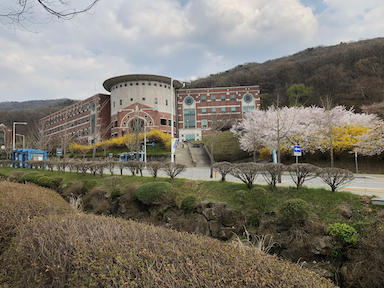

In [7]:
# top-5 predictions
print('1st prediction: ',idx2label[out_sort_ind[-1]],'\t with probability: ', out_sort_val[-1].detach().numpy(),'\n')
print('2nd prediction: ',idx2label[out_sort_ind[-2]],'\t with probability: ', out_sort_val[-2].detach().numpy(),'\n')
print('3rd prediction: ',idx2label[out_sort_ind[-3]],'\t with probability: ', out_sort_val[-3].detach().numpy(),'\n')
print('4th prediction: ',idx2label[out_sort_ind[-4]],'\t with probability: ', out_sort_val[-4].detach().numpy(),'\n')
print('5th prediction: ',idx2label[out_sort_ind[-5]],'\t with probability: ', out_sort_val[-5].detach().numpy(),'\n')

input_image

In [8]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Visualize filters (convolution kernels)

In [9]:
filters = net.conv1.weight.data.clone()
filters.shape

torch.Size([64, 3, 7, 7])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


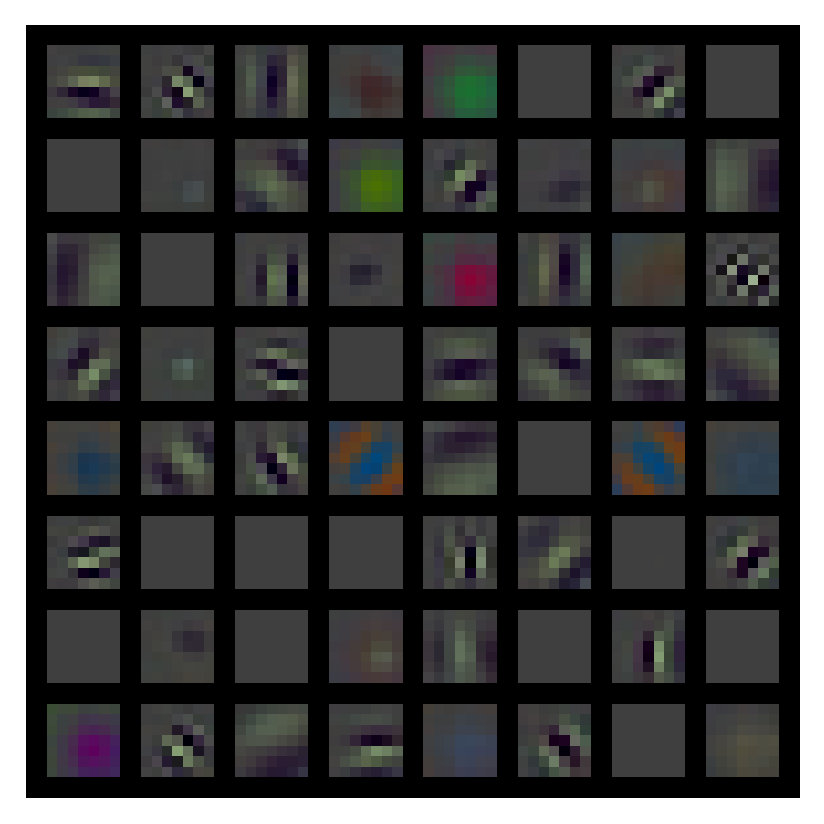

In [10]:
plt.figure(dpi=256)
plt.imshow(np.transpose(make_grid(filters+.5,8)*.5,[1,2,0]))
plt.axis('off')
plt.show()

## Get hidden layer outputs

In [11]:
net_ = nn.Sequential(*list(net.children())[:1])
for param in net_.parameters():
    param.requires_grad = False

In [12]:
out_ = net_(input_batch)
out__=out_[0].unsqueeze(dim=1)
out__.shape

torch.Size([64, 1, 112, 112])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 913.5, 913.5, -0.5)

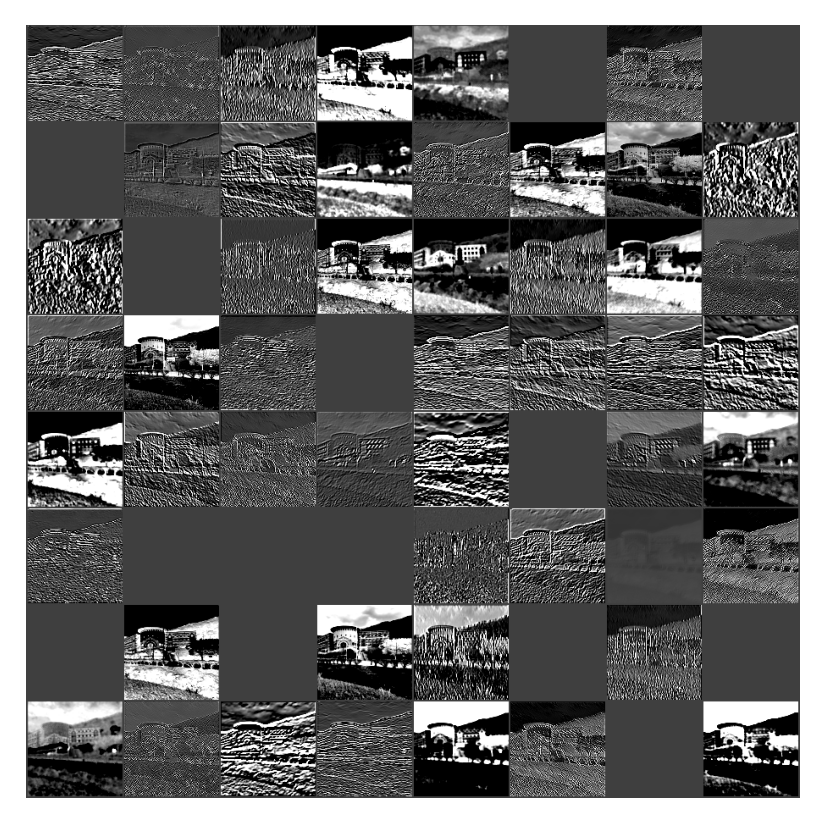

In [13]:
out__=make_grid(out__,8)
plt.figure(dpi=256)
plt.imshow(np.transpose((out__+.5)*.5,[1,2,0]))
plt.axis('off')

## Grad CAM
https://github.com/vickyliin/gradcam_plus_plus-pytorch


In [14]:
gradcam = GradCAM(net, net.layer4)
mask, _ = gradcam(input_batch)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


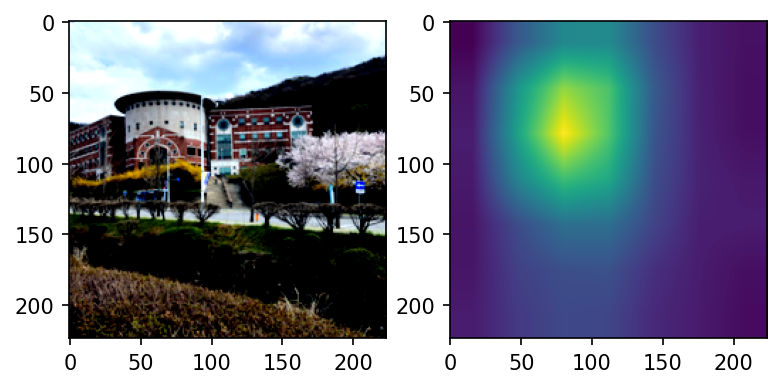

In [15]:
plt.figure(dpi=150)
plt.subplot(121)
plt.imshow(np.transpose((input_tensor+0.5)*.5,[1,2,0]))
plt.subplot(122)
plt.imshow(np.transpose(np.squeeze(mask)))